In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [2]:
# ddirectory set up 
os.chdir("..")


In [3]:
# loading data
data = pd.read_csv("data/churn.csv")


In [4]:
data.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
 
data = data.drop(data.columns[0:3], axis=1)

In [6]:
# changing columns categorical to numerical  and fill na median or mode 
column_equivalence = {}
features = list(data.columns)
for i, column in enumerate(data.dtypes):
    if column == "object":
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].mode())
        categorical_column = data[data.columns[i]].astype("category")
        current_column_equivalence = dict(enumerate(categorical_column.cat.categories))
        column_equivalence[i] = dict((v,k) for k,v in current_column_equivalence.items())
        data[data.columns[i]] = categorical_column.cat.codes
    else:
        data[data.columns[i]] = data[data.columns[i]].fillna(data[data.columns[i]].median())

In [7]:
column_equivalence

{1: {'France': 0, 'Germany': 1, 'Spain': 2}, 2: {'Female': 0, 'Male': 1}}

<Axes: xlabel='Exited', ylabel='count'>

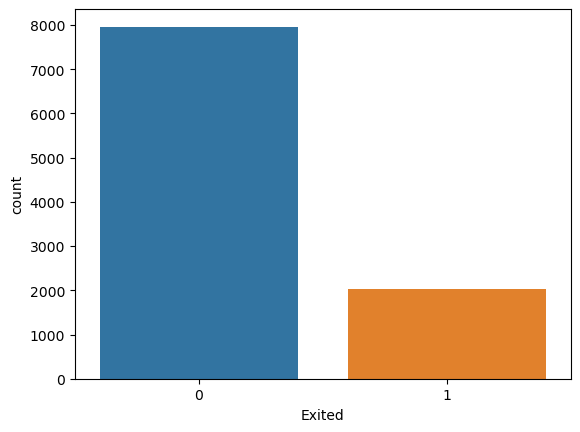

In [8]:
#el target  is unbalanced 
sns.countplot( data= data, x='Exited')

In [9]:
###target and features
X = data.copy()
y = X.pop(data.columns[-1])

In [10]:
# spliting train and tets
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

In [11]:
data.describe().T


,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Geography,10000.0,0.746300,0.827529,0.00,0.00,0.000,1.0000,2.00
Gender,10000.0,0.545700,0.497932,0.00,0.00,1.000,1.0000,1.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


## Data Sacling

In [13]:
##loking for index of columns that want to  scale 
columns_scale=[]
for index, column in enumerate(data.columns):
    if data[column].max() > 10:
        columns_scale.append(index)
        print(column, f"max number is: {data[column].max()}")
columns_scale

CreditScore max number is: 850
Age max number is: 92
Balance max number is: 250898.09
EstimatedSalary max number is: 199992.48


[0, 3, 5, 9]

In [14]:
scaler = ColumnTransformer(
[
        ("scale",StandardScaler(), columns_scale)],remainder= 'passthrough'
)

In [15]:
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

# Modelo 

we are going to try with different models to see wich is the best for this data  

In [16]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [17]:
reg = {
        'SVC' : SVC(),
        'GRADIENT' : GradientBoostingClassifier(),
        'LR': LogisticRegression(),
        'RF':RandomForestClassifier()}

params = {
    'SVC' : {
        'kernel' : ['linear', 'poly', 'rbf'],
        'gamma' : ['auto', 'scale'],
        'C' : [0.5,1,1.5,2,10],
        'class_weight':['balanced'],
        },

    'GRADIENT' : {
               'loss' : ['log_loss', 'exponential'],
               'learning_rate' : [0.01, 0.05,0.1,0.2,0.3,0.4],
               'n_estimators':[20,50,100,200]
           },

      'LR' :{
             'solver': ['lbfgs','newton-cg', 'sag', 'saga'],
             'C' : [0.5,1,1.5,2,10],
             'class_weight':['balanced']
             
           },

      'RF': {
          'n_estimators': [20,50,100,200],
          'criterion': ['gini', 'entropy', 'log_loss'],
          'class_weight':['balanced']
        
      }
          
        }

In [18]:
### check the best model 
best_model_SVC=None
best_model_GBC=None
best_model_LR=None
best_model_RF=None

primer_score = dict()

for name, reg in reg.items():

    grid_reg = GridSearchCV(reg, params[name], cv=3).fit(X_train, y_train.values.ravel())
    score = np.abs(grid_reg.best_score_)

    if score > 0.5:
        primer_score.update({name:score})
    
    if name == "SVC":
        best_model_SVC= grid_reg.best_estimator_
        
    if name == "GRADIENT":
        best_model_GBC= grid_reg.best_estimator_

    if name == 'LR':
        best_model_LR= grid_reg.best_estimator_ 
    
    else:
        best_model_RF= grid_reg.best_estimator_ 
    

In [19]:
primer_score

{'SVC': 0.7797001463225648,
 'GRADIENT': 0.857762613188168,
 'LR': 0.6986574380147065,
 'RF': 0.8579110205387487}

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [21]:
mejores_modelos= [best_model_SVC,best_model_GBC, best_model_LR,best_model_RF]
toal=0

for i,mod in  enumerate(mejores_modelos):
    print("***"*25)
    print(f"modelo {i+1}")
    print("***"*25)
    print(mod)
    print(f"accuracy score:{accuracy_score(y_test,mod.predict(X_test))}")
    print("confusion matrix")
    print(confusion_matrix(y_test,mod.predict(X_test)))
    

***************************************************************************
modelo 1
***************************************************************************
SVC(C=10, class_weight='balanced', gamma='auto')


accuracy score:0.7815151515151515
confusion matrix
[[2121  536]
 [ 185  458]]
***************************************************************************
modelo 2
***************************************************************************
GradientBoostingClassifier(learning_rate=0.3, loss='exponential',
                           n_estimators=50)
accuracy score:0.8675757575757576
confusion matrix
[[2560   97]
 [ 340  303]]
***************************************************************************
modelo 3
***************************************************************************
LogisticRegression(C=1, class_weight='balanced')
accuracy score:0.6978787878787879
confusion matrix
[[1862  795]
 [ 202  441]]
***************************************************************************
modelo 4
***************************************************************************
RandomForestClassifier(class_weight='balanced', criterion='log_loss')
accuracy score:0.8690909090909091
confusion matrix
[[2

## best result with  SVC

In [22]:
accuracy_score(y_test,best_model_SVC.predict(X_test))
confusion_matrix(y_test,best_model_SVC.predict(X_test))

array([[2121,  536],
       [ 185,  458]])

In [23]:
## saving the model an scaler 
import pickle
pickle.dump(best_model_SVC, open("model/model.pk", "wb"))
pickle.dump(column_equivalence, open("model/column_equivalence.pk", "wb"))
pickle.dump(features, open("model/features.pk", "wb"))
pickle.dump(scaler, open("model/scaler.pk", "wb"))